<a href="https://colab.research.google.com/github/edponce/DoyleInvestigators2/blob/main/Copy_of_project2_maria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WORD2VEC MODELING
# ADVERSARIAL PERTURBATION USING SYNONYM REPLACEMENT

# Import necessary modules

In [ ]:
# Import modules
import requests
import re, spacy
from collections import defaultdict
import pandas as pd
import numpy as np
import itertools
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MultipleLocator
%matplotlib inline
import random
from itertools import chain


In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

import pickle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from random import shuffle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


INFO - 17:24:11: 'pattern' package not found; tag filters are not available for English


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get book 

In [ ]:
def get_book(url):
  # Make the request
  r = requests.get(url)
  # Get the text
  book = r.text
  return book


In [ ]:
# # Store url
url_rine1 = 'http://www.gutenberg.org/cache/epub/434/pg434.txt' #circular staircase
url_rine2 = 'http://www.gutenberg.org/cache/epub/34020/pg34020.txt' #window white
url_rine3 = 'http://www.gutenberg.org/cache/epub/11127/pg11127.txt' #jennie brice
url_rine4 = 'http://www.gutenberg.org/cache/epub/2358/pg2358.txt' #after house
url_rine5 = 'http://www.gutenberg.org/files/1869/1869-0.txt' #lower ten

url_chri1 = 'http://www.gutenberg.org/files/863/863-0.txt' #mysterious affairs
url_chri2 = 'http://www.gutenberg.org/files/1155/1155-0.txt' #secrect adversary
url_chri3 = 'http://www.gutenberg.org/files/61168/61168-0.txt' #brown suit

url_doyl1 = 'http://www.gutenberg.org/files/244/244-0.txt' #study scarlet
url_doyl2 = 'http://www.gutenberg.org/files/2097/2097-0.txt' #sign four
url_doyl3 = 'http://www.gutenberg.org/cache/epub/31135/pg31135.txt' #ADVENTURES OF THE ELEVEN CUFF-BUTTONS


In [ ]:
book_rine1 = get_book(url_rine1)
book_rine2 = get_book(url_rine2)
book_rine3 = get_book(url_rine3)
book_rine4 = get_book(url_rine4)
book_rine5 = get_book(url_rine5)

book_chri1 = get_book(url_chri1)
book_chri2 = get_book(url_chri2)
book_chri3 = get_book(url_chri3)

book_doyl1 = get_book(url_doyl1)
book_doyl2 = get_book(url_doyl2)
book_doyl3 = get_book(url_doyl3)


# Extract contents from the novels

In [ ]:
def text_extractor(book, n, end_of_project = True, same_line_heading = False):
  if end_of_project:
    pattern = ("(CHAPTER)\s+" +                         # Group 1 selects the chapter string
              "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter number but excludes all caps word beginning title of the chapter
              "([A-Z \r\n'\",.!?-]+[\r\n])" +           # Group 3 selects the chapter title 
              "(?![a-z']|[A-Z.])" +                     # Chapter title ends before lowercase letters
              "(.*?)" +                                 # Group 4 selects the chapter contents
              "(?=CHAPTER (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+Project\s+|"
              "CHAPTER)")                               # chapter contents ends with a new chapter or the end of book
  else: 
    pattern = ("(CHAPTER)\s+" +                           
              "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + 
              "([A-Z \r\n'\",.!?-]+[\r\n])" +            
              "(?![a-z']|[A-Z.])" +                     
              "(.*?)" +                                 
              "(?=CHAPTER (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+the\s+Project\s+|"
              "CHAPTER)")                               
  
  if same_line_heading:
    chapters = same_line_heading_chap(book, end_of_project)
  else:
    chapters = re.findall(pattern, book, re.DOTALL)
  chapters = chapters[n:]
  c = 1
  text = []
  for chapter in chapters:
    chap_num = chapter[0] + " " + str(c)
    chap_title = chapter[2].replace('\r', '')
    chap_title = chap_title.replace('\n', ' ')
    chap_text = chapter[3]
    chap_text = chap_text.replace('â\x80\x9c', '\"')
    chap_text = chap_text.replace('â\x80\x9d', '\"')
    chap_text = chap_text.replace('â', '\"')
    chap_text = chap_text.replace('â', '\"')
    chap_text = chap_text.replace('\r', '')
    chap_text = chap_text.replace('\n', ' ')
    chap_text = re.sub('\n*; [0-9]; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
    if end_of_project:
     chap_text = re.sub('\n*; [0-9];\s*(CHAPTER [A-Z-]+\s*)|(End\s+of\s+Project\s+)\s*', '', chap_text)
    else:
     chap_text = re.sub('\n*; [0-9];\s*(CHAPTER [A-Z-]+\s*)|(End\s+of\s+the\s+Project\s+)\s*', '', chap_text)
    chap_text = re.sub(' \n*; [0-9]; \n*', '', chap_text)
    chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
    text.append(chap_text)
    c+=1
  return text


In [ ]:
# utility function for chapter seperator
def slicer(my_str,sub):
  index=my_str.find(sub)
  if index !=-1 :
    return [my_str[:index], my_str[index:]] 
  else :
    raise Exception('Sub string not found!')


def same_line_heading_chap(book, end_of = True):
  if end_of:
    pattern = ("(CHAPTER)"
              "(.*?)" +                                 
              "(?=CHAPTER (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+Project\s+|"
              "CHAPTER)") 
  else:
    pattern = ("(CHAPTER)"
              "(.*?)" +                                 
              "(?=CHAPTER (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+the\s+Project\s+|"
              "CHAPTER)") 

  chapter_ls = re.findall(pattern, book, re.DOTALL)
  chapters = []
  for chapter in chapter_ls:
    ch_nt, ch_c = slicer(chapter[1],'\r')
    ch_n, ch_t = slicer(ch_nt,'. ')
    chapters.append([chapter[0], ch_n, ch_t, ch_c])
  return chapters


In [ ]:
def doyle_text_extractor(book, n, end_of_project = True, same_line_heading = False):
  if end_of_project:
    pattern = ("(Chapter)\s+" +                         # Group 1 selects the chapter string
              "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter number but excludes all caps word beginning title of the chapter
              # "([A-Z a-z \r\n'\",.!?-]+[\r\n])" +           # Group 3 selects the chapter title 
              # "(?![a-z']|[\r\n])" +                     # Chapter title ends before lowercase letters
              "(.*?)\\b(?![\r\n]+(?=\.)\\b)" +   
              "(?![\r\n\r\n|[A-Z.]])" +                              
              "(.*?)" +                                 # Group 4 selects the chapter contents
              "(?=Chapter (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+Project\s+|"
              "Chapter)")                               # chapter contents ends with a new chapter or the end of book
  else: 
    pattern = ("(Chapter)\s+" +                           
              "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + 
              "([A-Z \r\n'\",.!?-]+[\r\n])" +            
              "(?![a-z']|[A-Z.])" +                     
              "(.*?)" +                                 
              "(?=Chapter (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+the\s+Project\s+|"
              "Chapter)")                                
  if same_line_heading:
    chapters = same_line_heading_chap(book, end_of_project)
  else:
    chapters = re.findall(pattern, book, re.DOTALL)
  chapters = chapters[n:]
  c = 1
  text = []
  for chapter in chapters:
    chap_num = chapter[0] + " " + str(c)
    chap_title = chapter[2].replace('\r', '')
    chap_title = chap_title.replace('\n', ' ')
    chap_text = chapter[3]
    chap_text = chap_text.replace('â\x80\x9c', '\"')
    chap_text = chap_text.replace('â\x80\x9d', '\"')
    chap_text = chap_text.replace('â\x80\x99', "'")
    chap_text = chap_text.replace('Å\x93', "a")
    chap_text = chap_text.replace('â\x80\x94', "-")
    chap_text = chap_text.replace('â\x80\x98', '')
    chap_text = chap_text.replace('â', '\"')
    chap_text = chap_text.replace('â', '\"')
    chap_text = chap_text.replace('\r', '')
    chap_text = chap_text.replace('_', '')
    chap_text = chap_text.replace('\n', ' ')
    chap_text = re.sub('\n*; [0-9]; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
    if end_of_project:
     chap_text = re.sub('\n*; [0-9];\s*(Chapter [A-Z-]+\s*)|(End\s+of\s+Project\s+)\s*', '', chap_text)
    else:
     chap_text = re.sub('\n*; [0-9];\s*(Chapter [A-Z-]+\s*)|(End\s+of\s+the\s+Project\s+)\s*', '', chap_text)
    chap_text = re.sub(' \n*; [0-9]; \n*', '', chap_text)
    chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
    text.append(chap_text)
    c+=1
  return text



In [ ]:
d_rine1 = text_extractor(book_rine1, 0)
d_rine2 = text_extractor(book_rine2, 0, False)
d_rine3 = text_extractor(book_rine3, 0)
d_rine4 = text_extractor(book_rine4, 0)
d_rine5 = text_extractor(book_rine5, 0, True, True)

d_chri1 = text_extractor(book_chri1, 13, True, True)
d_chri2 = text_extractor(book_chri2, 28, False, True)
d_chri3 = text_extractor(book_chri3, 0)

d_doyl1 = doyle_text_extractor(book_doyl1, 0, True, True)
d_doyl2 = doyle_text_extractor(book_doyl2, 0) 
d_doyl3 = text_extractor(book_doyl3, 0, False)


In [ ]:
# print(len(d_rine1))
# print(len(d_rine2))
# print(len(d_rine3))
# print(len(d_rine4))
# print(len(d_rine5))

# rine_text = [d_rine1, d_rine2, d_rine3, d_rine4, d_rine5]
# rine_text = ''.join(list(chain(*rine_text)))

# file = open("/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data_raw/Rinehart.txt","w")   
# file.write(rine_text) 
# file.close() #to change file access modes 
  
# rine = open("/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data_raw/Rinehart.txt","r+")  
# rine = rine.read()
# print(len(rine.split()))


# Read files from authors
For training the w2v we use the whole corpus of each author


In [ ]:
rine = open("/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_raw/Rinehart.txt","r+")  
rine = rine.read()
print(len(rine.split()))

doyle = open("/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_raw/Doyle.txt","r+")  
doyle = doyle.read()
print(len(doyle.split()))

christie = open("/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_raw/Christie.txt","r+")  
christie = christie.read()
print(len(christie.split()))


285029
271957
244217


# 2 w2v models: sentence, and 50, 300 emb_size

# Prepare Data for w2v training

In [ ]:
# sent_rine = nltk.tokenize.sent_tokenize(rine)
# df_sent = pd.DataFrame({'Text': sent_rine})

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def tokenizer(rine):
  sent = nltk.tokenize.sent_tokenize(rine)
  t = time()
  lemmatized = []
  for s in sent:
    s = re.split(' |\--', s)
    w_ls = []
    for w in s:
      w = w.lower()
      w = re.sub('[,"\.\'&\|:@>*;/=?!\']', "", w)
      w = re.sub('^[0-9\.]*$', "", w)
      w = re.sub("[^A-Za-z']+", " ", w)
      w = wnl.lemmatize(w, pos='v')
      w = wnl.lemmatize(w, pos='n')
      w_ls.append(w)
    while "" in w_ls:
      w_ls.remove("")
    lemmatized.append(w_ls)

  print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
  return lemmatized

In [ ]:
#w2v_token_ls = tokenizer(rine)
#w2v_token_ls[:20]

In [ ]:
w2v_token_ls_rine = tokenizer(rine)
w2v_token_ls_rine[:20]

w2v_token_ls_doyle = tokenizer(doyle)
w2v_token_ls_doyle[:20]

w2v_token_ls_christie = tokenizer(christie)
w2v_token_ls_christie[:20]

Time to clean up everything: 0.05 mins
Time to clean up everything: 0.05 mins
Time to clean up everything: 0.04 mins


[['im', 'really', 'pin', 'my', 'faith', 'to', 'mr'],
 ['carter'],
 ['then', 'i', 'shouldnt'],
 ['why'],
 ['just', 'an', 'idea', 'of', 'mine'],
 ['oh', 'but', 'he', 'must', 'do', 'something'],
 ['there', 'no', 'one', 'else'],
 ['by',
  'the',
  'way',
  'i',
  'forget',
  'to',
  'tell',
  'you',
  'of',
  'a',
  'queer',
  'thing',
  'that',
  'happen',
  'this',
  'morning'],
 ['and',
  'she',
  'narrate',
  'her',
  'encounter',
  'with',
  'sir',
  'jam',
  'peel',
  'edgerton'],
 ['julius', 'be', 'interest'],
 ['what', 'do', 'the', 'guy', 'mean', 'do', 'you', 'think'],
 ['he', 'ask'],
 ['i', 'dont', 'quite', 'know', 'say', 'tuppence', 'meditatively'],
 ['but',
  'i',
  'think',
  'that',
  'in',
  'an',
  'ambiguous',
  'legal',
  'without',
  'prejudishish',
  'lawyer',
  'way',
  'he',
  'be',
  'try',
  'to',
  'warn',
  'me'],
 ['why', 'should', 'he'],
 ['i', 'dont', 'know', 'confess', 'tuppence'],
 ['but', 'he', 'look', 'kind', 'and', 'simply', 'awfully', 'clever'],
 ['i',
  '

# Word2Vec

In [ ]:
def train_w2v(sentences, filename, size):
  cores = multiprocessing.cpu_count() # Count the number of cores in a computer
  print('cores: ', cores)
  w2v_model = Word2Vec(min_count=1,
                      window=12,
                      sg=0, #cbow
                      size=size,
                      sample=6e-5, 
                      alpha=0.05, 
                      min_alpha=0.00004, 
                      negative=200,
                      workers=cores)

  # building the vocabulary table
  t1 = time()
  w2v_model.build_vocab(sentences, progress_per=500)
  print('Time to build vocab: {} mins'.format(round((time() - t1) / 60, 2)))

  # training model
  t2 = time()
  w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100, report_delay=5)
  print('Time to train the model: {} mins'.format(round((time() - t2) / 60, 2)))

  # save the model to disk
  pickle.dump(w2v_model, open(filename, 'wb'))

  # As we do not plan to train the model any further, we are calling init_sims(), 
  # which will make the model much more memory-efficient:
  w2v_model.init_sims(replace=True)
  return w2v_model

In [ ]:
# w2v_sent_300 = train_w2v(w2v_token_ls, '/content/drive/My Drive/ECE 692/project2/w2v_model_dim300_window12_cb.sav', 300)
# w2v_sent_50 = train_w2v(w2v_token_ls, '/content/drive/My Drive/ECE 692/project2/w2v_model_dim50_window12_cb.sav', 50)


In [ ]:
rine_w2v_sent_300 = train_w2v(w2v_token_ls, '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/rine_w2v_model_dim300_window12_cb.sav', 300)
rine_w2v_sent_50 = train_w2v(w2v_token_ls, '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/rine_w2v_model_dim50_window12_cb.sav', 50)


doyle_w2v_sent_300 = train_w2v(w2v_token_ls, '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/doyle_w2v_model_dim300_window12_cb.sav', 300)
doyle_w2v_sent_50 = train_w2v(w2v_token_ls, '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/doyle_w2v_model_dim50_window12_cb.sav', 50)

christie_w2v_sent_300 = train_w2v(w2v_token_ls, '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/christie_w2v_model_dim300_window12_cb.sav', 300)
christie_w2v_sent_50 = train_w2v(w2v_token_ls, '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/christie_w2v_model_dim50_window12_cb.sav', 50)

INFO - 18:21:32: collecting all words and their counts
INFO - 18:21:32: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:21:32: PROGRESS: at sentence #500, processed 8245 words, keeping 1588 word types
INFO - 18:21:32: PROGRESS: at sentence #1000, processed 14857 words, keeping 2087 word types
INFO - 18:21:32: PROGRESS: at sentence #1500, processed 21502 words, keeping 2549 word types
INFO - 18:21:32: PROGRESS: at sentence #2000, processed 28743 words, keeping 2971 word types
INFO - 18:21:32: PROGRESS: at sentence #2500, processed 35816 words, keeping 3276 word types
INFO - 18:21:32: PROGRESS: at sentence #3000, processed 42703 words, keeping 3604 word types
INFO - 18:21:32: PROGRESS: at sentence #3500, processed 49440 words, keeping 3911 word types
INFO - 18:21:32: PROGRESS: at sentence #4000, processed 55739 words, keeping 4128 word types
INFO - 18:21:32: PROGRESS: at sentence #4500, processed 63384 words, keeping 4384 word types
INFO - 18:21:32: PROGRESS: 

cores:  2


INFO - 18:21:32: effective_min_count=1 retains 9699 unique words (100% of original 9699, drops 0)
INFO - 18:21:32: effective_min_count=1 leaves 286758 word corpus (100% of original 286758, drops 0)
INFO - 18:21:32: deleting the raw counts dictionary of 9699 items
INFO - 18:21:32: sample=6e-05 downsamples 687 most-common words
INFO - 18:21:32: downsampling leaves estimated 98516 word corpus (34.4% of prior 286758)
INFO - 18:21:32: estimated required memory for 9699 words and 300 dimensions: 28127100 bytes
INFO - 18:21:32: resetting layer weights
INFO - 18:21:34: training model with 2 workers on 9699 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=200 window=12


Time to build vocab: 0.04 mins


INFO - 18:21:35: EPOCH 1 - PROGRESS: at 22.63% examples, 23744 words/s, in_qsize 3, out_qsize 0
INFO - 18:21:38: worker thread finished; awaiting finish of 1 more threads
INFO - 18:21:38: worker thread finished; awaiting finish of 0 more threads
INFO - 18:21:38: EPOCH - 1 : training on 286758 raw words (98419 effective words) took 3.4s, 28926 effective words/s
INFO - 18:21:39: EPOCH 2 - PROGRESS: at 29.22% examples, 28584 words/s, in_qsize 3, out_qsize 0
INFO - 18:21:41: worker thread finished; awaiting finish of 1 more threads
INFO - 18:21:41: worker thread finished; awaiting finish of 0 more threads
INFO - 18:21:41: EPOCH - 2 : training on 286758 raw words (98294 effective words) took 3.1s, 31212 effective words/s
INFO - 18:21:42: EPOCH 3 - PROGRESS: at 29.22% examples, 28281 words/s, in_qsize 3, out_qsize 0
INFO - 18:21:44: worker thread finished; awaiting finish of 1 more threads
INFO - 18:21:44: worker thread finished; awaiting finish of 0 more threads
INFO - 18:21:44: EPOCH - 3 :

Time to train the model: 5.81 mins


WARNING - 18:27:23: consider setting layer size to a multiple of 4 for greater performance
INFO - 18:27:23: collecting all words and their counts
INFO - 18:27:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:27:23: PROGRESS: at sentence #500, processed 8245 words, keeping 1588 word types
INFO - 18:27:23: PROGRESS: at sentence #1000, processed 14857 words, keeping 2087 word types
INFO - 18:27:23: PROGRESS: at sentence #1500, processed 21502 words, keeping 2549 word types
INFO - 18:27:23: PROGRESS: at sentence #2000, processed 28743 words, keeping 2971 word types
INFO - 18:27:23: PROGRESS: at sentence #2500, processed 35816 words, keeping 3276 word types
INFO - 18:27:23: PROGRESS: at sentence #3000, processed 42703 words, keeping 3604 word types
INFO - 18:27:23: PROGRESS: at sentence #3500, processed 49440 words, keeping 3911 word types
INFO - 18:27:23: PROGRESS: at sentence #4000, processed 55739 words, keeping 4128 word types
INFO - 18:27:23: PROGRESS: at

cores:  2


INFO - 18:27:23: effective_min_count=1 retains 9699 unique words (100% of original 9699, drops 0)
INFO - 18:27:23: effective_min_count=1 leaves 286758 word corpus (100% of original 286758, drops 0)
INFO - 18:27:23: deleting the raw counts dictionary of 9699 items
INFO - 18:27:23: sample=6e-05 downsamples 687 most-common words
INFO - 18:27:23: downsampling leaves estimated 98516 word corpus (34.4% of prior 286758)
INFO - 18:27:23: estimated required memory for 9699 words and 50 dimensions: 8729100 bytes
INFO - 18:27:23: resetting layer weights
INFO - 18:27:25: training model with 2 workers on 9699 vocabulary and 50 features, using sg=0 hs=0 sample=6e-05 negative=200 window=12


Time to build vocab: 0.04 mins


INFO - 18:27:26: EPOCH 1 - PROGRESS: at 35.92% examples, 32814 words/s, in_qsize 3, out_qsize 0
INFO - 18:27:28: worker thread finished; awaiting finish of 1 more threads
INFO - 18:27:28: worker thread finished; awaiting finish of 0 more threads
INFO - 18:27:28: EPOCH - 1 : training on 286758 raw words (98487 effective words) took 2.6s, 38214 effective words/s
INFO - 18:27:29: EPOCH 2 - PROGRESS: at 35.92% examples, 37439 words/s, in_qsize 3, out_qsize 0
INFO - 18:27:30: worker thread finished; awaiting finish of 1 more threads
INFO - 18:27:30: worker thread finished; awaiting finish of 0 more threads
INFO - 18:27:30: EPOCH - 2 : training on 286758 raw words (98638 effective words) took 2.4s, 41443 effective words/s
INFO - 18:27:31: EPOCH 3 - PROGRESS: at 42.15% examples, 40005 words/s, in_qsize 3, out_qsize 0
INFO - 18:27:33: worker thread finished; awaiting finish of 1 more threads
INFO - 18:27:33: worker thread finished; awaiting finish of 0 more threads
INFO - 18:27:33: EPOCH - 3 :

Time to train the model: 4.29 mins
cores:  2


INFO - 18:31:43: PROGRESS: at sentence #10500, processed 148176 words, keeping 6925 word types
INFO - 18:31:43: PROGRESS: at sentence #11000, processed 154086 words, keeping 7030 word types
INFO - 18:31:43: PROGRESS: at sentence #11500, processed 159955 words, keeping 7143 word types
INFO - 18:31:43: PROGRESS: at sentence #12000, processed 165584 words, keeping 7237 word types
INFO - 18:31:43: PROGRESS: at sentence #12500, processed 171141 words, keeping 7326 word types
INFO - 18:31:43: PROGRESS: at sentence #13000, processed 178661 words, keeping 7599 word types
INFO - 18:31:43: PROGRESS: at sentence #13500, processed 184967 words, keeping 7753 word types
INFO - 18:31:43: PROGRESS: at sentence #14000, processed 191041 words, keeping 7834 word types
INFO - 18:31:43: PROGRESS: at sentence #14500, processed 197423 words, keeping 7945 word types
INFO - 18:31:43: PROGRESS: at sentence #15000, processed 203709 words, keeping 8048 word types
INFO - 18:31:43: PROGRESS: at sentence #15500, pro

Time to build vocab: 0.04 mins


INFO - 18:31:46: EPOCH 1 - PROGRESS: at 22.63% examples, 23010 words/s, in_qsize 4, out_qsize 0
INFO - 18:31:49: worker thread finished; awaiting finish of 1 more threads
INFO - 18:31:49: worker thread finished; awaiting finish of 0 more threads
INFO - 18:31:49: EPOCH - 1 : training on 286758 raw words (98487 effective words) took 3.5s, 28401 effective words/s
INFO - 18:31:50: EPOCH 2 - PROGRESS: at 29.22% examples, 28545 words/s, in_qsize 3, out_qsize 0
INFO - 18:31:52: worker thread finished; awaiting finish of 1 more threads
INFO - 18:31:52: worker thread finished; awaiting finish of 0 more threads
INFO - 18:31:52: EPOCH - 2 : training on 286758 raw words (98578 effective words) took 3.2s, 31014 effective words/s
INFO - 18:31:53: EPOCH 3 - PROGRESS: at 29.22% examples, 27802 words/s, in_qsize 3, out_qsize 0
INFO - 18:31:55: worker thread finished; awaiting finish of 1 more threads
INFO - 18:31:55: worker thread finished; awaiting finish of 0 more threads
INFO - 18:31:55: EPOCH - 3 :

Time to train the model: 5.77 mins


WARNING - 18:37:32: consider setting layer size to a multiple of 4 for greater performance
INFO - 18:37:32: collecting all words and their counts
INFO - 18:37:32: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:37:32: PROGRESS: at sentence #500, processed 8245 words, keeping 1588 word types
INFO - 18:37:32: PROGRESS: at sentence #1000, processed 14857 words, keeping 2087 word types
INFO - 18:37:32: PROGRESS: at sentence #1500, processed 21502 words, keeping 2549 word types
INFO - 18:37:32: PROGRESS: at sentence #2000, processed 28743 words, keeping 2971 word types
INFO - 18:37:32: PROGRESS: at sentence #2500, processed 35816 words, keeping 3276 word types
INFO - 18:37:32: PROGRESS: at sentence #3000, processed 42703 words, keeping 3604 word types
INFO - 18:37:32: PROGRESS: at sentence #3500, processed 49440 words, keeping 3911 word types
INFO - 18:37:32: PROGRESS: at sentence #4000, processed 55739 words, keeping 4128 word types
INFO - 18:37:32: PROGRESS: at

cores:  2


INFO - 18:37:32: effective_min_count=1 retains 9699 unique words (100% of original 9699, drops 0)
INFO - 18:37:32: effective_min_count=1 leaves 286758 word corpus (100% of original 286758, drops 0)
INFO - 18:37:32: deleting the raw counts dictionary of 9699 items
INFO - 18:37:32: sample=6e-05 downsamples 687 most-common words
INFO - 18:37:32: downsampling leaves estimated 98516 word corpus (34.4% of prior 286758)
INFO - 18:37:32: estimated required memory for 9699 words and 50 dimensions: 8729100 bytes
INFO - 18:37:32: resetting layer weights
INFO - 18:37:34: training model with 2 workers on 9699 vocabulary and 50 features, using sg=0 hs=0 sample=6e-05 negative=200 window=12


Time to build vocab: 0.04 mins


INFO - 18:37:35: EPOCH 1 - PROGRESS: at 35.94% examples, 34478 words/s, in_qsize 3, out_qsize 0
INFO - 18:37:36: worker thread finished; awaiting finish of 1 more threads
INFO - 18:37:36: worker thread finished; awaiting finish of 0 more threads
INFO - 18:37:36: EPOCH - 1 : training on 286758 raw words (98487 effective words) took 2.6s, 38346 effective words/s
INFO - 18:37:38: EPOCH 2 - PROGRESS: at 42.57% examples, 39634 words/s, in_qsize 3, out_qsize 0
INFO - 18:37:39: worker thread finished; awaiting finish of 1 more threads
INFO - 18:37:39: worker thread finished; awaiting finish of 0 more threads
INFO - 18:37:39: EPOCH - 2 : training on 286758 raw words (98638 effective words) took 2.4s, 41767 effective words/s
INFO - 18:37:40: EPOCH 3 - PROGRESS: at 42.57% examples, 39919 words/s, in_qsize 3, out_qsize 0
INFO - 18:37:41: worker thread finished; awaiting finish of 1 more threads
INFO - 18:37:41: worker thread finished; awaiting finish of 0 more threads
INFO - 18:37:41: EPOCH - 3 :

Time to train the model: 4.31 mins
cores:  2


INFO - 18:41:52: PROGRESS: at sentence #8000, processed 113171 words, keeping 6157 word types
INFO - 18:41:52: PROGRESS: at sentence #8500, processed 120563 words, keeping 6349 word types
INFO - 18:41:52: PROGRESS: at sentence #9000, processed 126991 words, keeping 6504 word types
INFO - 18:41:52: PROGRESS: at sentence #9500, processed 134743 words, keeping 6640 word types
INFO - 18:41:52: PROGRESS: at sentence #10000, processed 141938 words, keeping 6805 word types
INFO - 18:41:52: PROGRESS: at sentence #10500, processed 148176 words, keeping 6925 word types
INFO - 18:41:52: PROGRESS: at sentence #11000, processed 154086 words, keeping 7030 word types
INFO - 18:41:52: PROGRESS: at sentence #11500, processed 159955 words, keeping 7143 word types
INFO - 18:41:52: PROGRESS: at sentence #12000, processed 165584 words, keeping 7237 word types
INFO - 18:41:52: PROGRESS: at sentence #12500, processed 171141 words, keeping 7326 word types
INFO - 18:41:52: PROGRESS: at sentence #13000, process

Time to build vocab: 0.04 mins


INFO - 18:41:56: EPOCH 1 - PROGRESS: at 22.63% examples, 23747 words/s, in_qsize 4, out_qsize 0
INFO - 18:41:58: worker thread finished; awaiting finish of 1 more threads
INFO - 18:41:58: worker thread finished; awaiting finish of 0 more threads
INFO - 18:41:58: EPOCH - 1 : training on 286758 raw words (98487 effective words) took 3.4s, 29170 effective words/s
INFO - 18:41:59: EPOCH 2 - PROGRESS: at 29.22% examples, 28519 words/s, in_qsize 3, out_qsize 0
INFO - 18:42:01: worker thread finished; awaiting finish of 1 more threads
INFO - 18:42:01: worker thread finished; awaiting finish of 0 more threads
INFO - 18:42:01: EPOCH - 2 : training on 286758 raw words (98638 effective words) took 3.2s, 31183 effective words/s
INFO - 18:42:02: EPOCH 3 - PROGRESS: at 29.22% examples, 29269 words/s, in_qsize 4, out_qsize 0
INFO - 18:42:04: worker thread finished; awaiting finish of 1 more threads
INFO - 18:42:04: worker thread finished; awaiting finish of 0 more threads
INFO - 18:42:04: EPOCH - 3 :

Time to train the model: 5.79 mins


WARNING - 18:47:42: consider setting layer size to a multiple of 4 for greater performance
INFO - 18:47:42: collecting all words and their counts
INFO - 18:47:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:47:42: PROGRESS: at sentence #500, processed 8245 words, keeping 1588 word types
INFO - 18:47:42: PROGRESS: at sentence #1000, processed 14857 words, keeping 2087 word types
INFO - 18:47:42: PROGRESS: at sentence #1500, processed 21502 words, keeping 2549 word types
INFO - 18:47:42: PROGRESS: at sentence #2000, processed 28743 words, keeping 2971 word types
INFO - 18:47:42: PROGRESS: at sentence #2500, processed 35816 words, keeping 3276 word types
INFO - 18:47:42: PROGRESS: at sentence #3000, processed 42703 words, keeping 3604 word types
INFO - 18:47:42: PROGRESS: at sentence #3500, processed 49440 words, keeping 3911 word types
INFO - 18:47:42: PROGRESS: at sentence #4000, processed 55739 words, keeping 4128 word types
INFO - 18:47:42: PROGRESS: at

cores:  2


INFO - 18:47:42: effective_min_count=1 retains 9699 unique words (100% of original 9699, drops 0)
INFO - 18:47:42: effective_min_count=1 leaves 286758 word corpus (100% of original 286758, drops 0)
INFO - 18:47:42: deleting the raw counts dictionary of 9699 items
INFO - 18:47:42: sample=6e-05 downsamples 687 most-common words
INFO - 18:47:42: downsampling leaves estimated 98516 word corpus (34.4% of prior 286758)
INFO - 18:47:42: estimated required memory for 9699 words and 50 dimensions: 8729100 bytes
INFO - 18:47:42: resetting layer weights
INFO - 18:47:44: training model with 2 workers on 9699 vocabulary and 50 features, using sg=0 hs=0 sample=6e-05 negative=200 window=12


Time to build vocab: 0.04 mins


INFO - 18:47:46: EPOCH 1 - PROGRESS: at 35.94% examples, 33968 words/s, in_qsize 3, out_qsize 0
INFO - 18:47:47: worker thread finished; awaiting finish of 1 more threads
INFO - 18:47:47: worker thread finished; awaiting finish of 0 more threads
INFO - 18:47:47: EPOCH - 1 : training on 286758 raw words (98487 effective words) took 2.6s, 38396 effective words/s
INFO - 18:47:48: EPOCH 2 - PROGRESS: at 39.15% examples, 40420 words/s, in_qsize 3, out_qsize 0
INFO - 18:47:49: worker thread finished; awaiting finish of 1 more threads
INFO - 18:47:49: worker thread finished; awaiting finish of 0 more threads
INFO - 18:47:49: EPOCH - 2 : training on 286758 raw words (98638 effective words) took 2.4s, 40758 effective words/s
INFO - 18:47:50: EPOCH 3 - PROGRESS: at 35.92% examples, 37451 words/s, in_qsize 3, out_qsize 0
INFO - 18:47:52: worker thread finished; awaiting finish of 1 more threads
INFO - 18:47:52: worker thread finished; awaiting finish of 0 more threads
INFO - 18:47:52: EPOCH - 3 :

Time to train the model: 4.3 mins


In [ ]:
def tsnescatterplot(model, word, list_names, size):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 or 50 to 21 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)
    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [ ]:
#load model
# w2v_sent_300 = pickle.load(open('/content/drive/My Drive/ECE692 NLP/Project 2/w2v_model_dim300_window12_cb.sav', 'rb'))
# w2v_sent_50 = pickle.load(open('/content/drive/My Drive/ECE692 NLP/Project 2/w2v_model_dim50_window12_cb.sav', 'rb'))


INFO - 23:50:01: precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


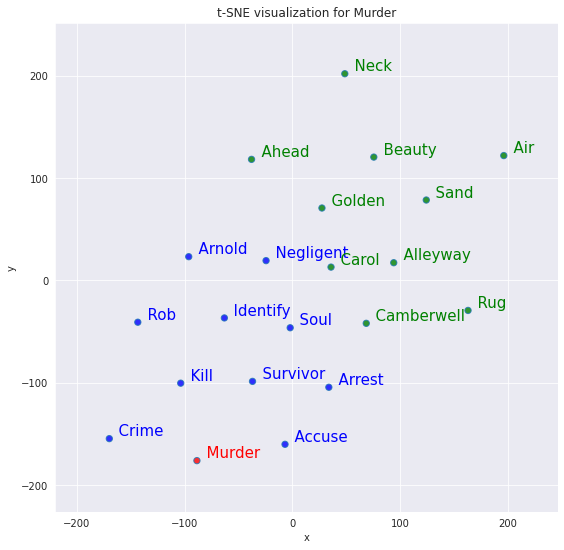

In [ ]:
tsnescatterplot(w2v_sent_300, 'murder', [i[0] for i in w2v_sent_300.wv.most_similar(negative=["murder"])], 300)

INFO - 23:50:05: precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


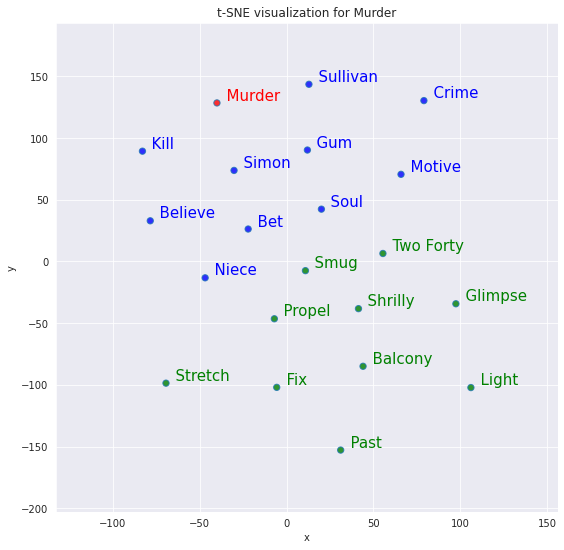

In [ ]:
tsnescatterplot(w2v_sent_50, 'murder', [i[0] for i in w2v_sent_50.wv.most_similar(negative=["murder"])], 50)

In [ ]:
vocab_50 = defaultdict(dict)

for x in list(w2v_sent_50.wv.vocab.keys()):
  vocab_50[x] = w2v_sent_50[x]

vocab_50['unk'] = np.average(w2v_sent_50[list(w2v_sent_50.wv.vocab.keys())], axis=0)

vocab_50 = dict(vocab_50)

len(vocab_50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


9700

In [ ]:
vocab_300 = defaultdict(dict)

for x in list(w2v_sent_300.wv.vocab.keys()):
  vocab_300[x] = w2v_sent_300[x]
  
vocab_300['unk'] = np.average(w2v_sent_300[list(w2v_sent_300.wv.vocab.keys())], axis=0)

vocab_300 = dict(vocab_300)

len(vocab_300)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


9700

In [ ]:
# try:
#     import cPickle as pickle
# except ImportError:  # Python 3.x
#     import pickle

# with open('/content/drive/My Drive/ECE 692/project2/vocab_dim50_window12_cb.p', 'wb') as fp:
#     pickle.dump(vocab_50, fp, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/My Drive/ECE 692/project2/vocab_dim50_window12_cb.p', 'rb') as fp:
#     vocab50 = pickle.load(fp)

# len(vocab50)

9700

In [ ]:
# try:
#     import cPickle as pickle
# except ImportError:  # Python 3.x
#     import pickle

# with open('/content/drive/My Drive/ECE 692/project2/vocab_dim300_window12_cb.p', 'wb') as fp:
#     pickle.dump(vocab_300, fp, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/My Drive/ECE 692/project2/vocab_dim300_window12_cb.p', 'rb') as fp:
#     vocab300 = pickle.load(fp)

# len(vocab300)

9700

# Adversarial Perturbation: Synonym replacement

# Steps: 
-> test data 

-> 350/ 1400/ 3500 split

-> get synonyms of singular noun, present tense singular verb, adjective, adverb

-> word >= 4 characters) 

-> filter synonyms (exclude if same word/ plural/ name) 

-> pick the synonym with the highest similarity score (SpaCy) (has to be more that 0.2)

In [ ]:
# !python -m spacy download en_core_web_lg


In [ ]:
from itertools import chain
import spacy, nltk
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pylab

wnl = WordNetLemmatizer()
nlp = spacy.load('en_core_web_lg')

In [ ]:
file = "/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data_raw/Christie_10.txt"
chri = open(file,"r+")  
chri = chri.read()


In [ ]:
# function that creates the data units
def get_units(data, unit_length):
  list_of_sentences = nltk.tokenize.sent_tokenize(data)
  UNIT_LENGTH = unit_length
  TOTAL_LENGTH = 0
  curr_unit_sentence = []
  text_in_units = []

  for sentence in list_of_sentences:
    sentence = sentence.split()
    curr_length = len(sentence)

    if TOTAL_LENGTH == 0:
      if curr_length >= UNIT_LENGTH:
        #curr_unit_sentence = sentence[:UNIT_LENGTH]
        text_in_units.append(sentence)
        curr_unit_sentence=[]
      else:
        curr_unit_sentence.append(sentence)
        TOTAL_LENGTH += curr_length
    else:
      if TOTAL_LENGTH + curr_length >= UNIT_LENGTH:
        #diff = UNIT_LENGTH - TOTAL_LENGTH
        #split_sentence2 = sentence[:diff]

        curr_unit_sentence.append(sentence)
        
        text_in_units.append(curr_unit_sentence)
        TOTAL_LENGTH = 0
        curr_unit_sentence =[]
      else:
        #diff = UNIT_LENGTH - TOTAL_LENGTH
        #split_sentence3 = sentence[:diff]

        curr_unit_sentence.append(sentence)
  
        TOTAL_LENGTH += curr_length
  return text_in_units

In [ ]:
chri_10_350 = get_units(chri, 350)
print(len(chri_10_350))
chri_10_1400 = get_units(chri, 1400)
print(len(chri_10_1400))
chri_10_3500 = get_units(chri, 3500)
print(len(chri_10_3500))

len(chri_10_350[0])

In [ ]:
def get_similarity(word, synonyms):
  sim_ls = []
  for w in synonyms:
    words = word + ' ' + w
    tokens = nlp(words)  
    token1, token2 = tokens[0], tokens[1] 
    sim = token1.similarity(token2)
    sim = "{:.2f}".format(sim)
    # print(w, " Similarity:", sim)
    if sim != "{:.2f}".format(1.0):
      sim_ls.append(sim)
  m_sim = max(sim_ls)
  return synonyms[sim_ls.index(m_sim)], m_sim

In [ ]:
def syn_generator(word):
  synonyms = []
  for syn in wordnet.synsets(word): 
      for l in syn.lemmas(): 
          synonyms.append(l.name())
  return synonyms

In [ ]:
def check_for_duplicates(word, ls):
  ls_refine = []
  for w in ls:
    if (all(x in list(wnl.lemmatize(w.lower(), pos = 'n')) for x in list(wnl.lemmatize(word.lower(), pos = 'n'))) or
        all(x in list(wnl.lemmatize(w.lower(), pos = 'v')) for x in list(wnl.lemmatize(word.lower(), pos = 'v')))) == False:
      ls_refine.append(w)
  return ls_refine

In [ ]:
def perturb_data(data):
  syn_dict = defaultdict(dict)
  tokenized = list(chain(*data))
  x = 0
  for (word, pos) in nltk.pos_tag(tokenized):
    if len(list(word)) >= 4:
      if (pos == 'NN' or pos == 'VBP' or 
          pos == 'JJ' or pos == 'RB'):
        syn_ls = list(set(syn_generator(word)) - set([word]))
        syn_ref = check_for_duplicates(word, syn_ls)
        if syn_ref:
          w, score = get_similarity(word, syn_ref)
          if (score > "{:.2f}".format(0.2)):
            # print('base word: ', word, ' - synonym: ', w, ' - score: ', score)
            syn_dict[word] = w
            if word != 'clung':
              tokenized[tokenized.index(word)] = w
            text = ' '.join(tokenized)
            x += 1
  return dict(syn_dict), text, len(tokenized), tokenized

In [ ]:
def apply_perturbation(data, un):
  dict_ls, perturbed_text_ls, per_ratio, tok_ls = [], [], [], []
  for i in range(len(data)):
    dicts, text, le, tok = perturb_data(data[i])
    dict_ls.append(dicts)
    perturbed_text_ls.append(text)
    tok_ls.append(tok)
    print('Perturbation Ratio: ', (len(dicts)/un)*100, '%')
    per_ratio.append((len(dicts)/un)*100)
  return dict_ls, perturbed_text_ls, per_ratio, tok_ls

In [ ]:
# syn_dict_350, perturbed_text_350, per_ratio_350, toks_350 = apply_perturbation(chri_10_350, 350)
# syn_dict_1400, perturbed_text_1400, per_ratio_1400, toks_1400 = apply_perturbation(chri_10_1400, 1400)
# syn_dict_3500, perturbed_text_3500, per_ratio_3500, toks_3500 = apply_perturbation(chri_10_3500, 3500)

In [ ]:
def create_df(data, label, data_unit):
  data_flat = [x[:data_unit] for x in data]
  df = pd.DataFrame(data_flat, columns = ['word_'+str(i) for i in range(data_unit)])
  label = [label] * len(data_flat) # create list with labels
  df['Label'] = label # add label column
  #display(df.head(5))
  print(df.shape)

  return df

df1 = create_df(toks_350, 'Christie', 350)
df2 = create_df(toks_1400, 'Christie', 1400)
df3 = create_df(toks_3500, 'Christie', 3500)

In [ ]:
# df1.to_csv('/content/drive/My Drive/ECE 692/project2/perturbed_christie_350.csv', index=False)
# df2.to_csv('/content/drive/My Drive/ECE 692/project2/perturbed_christie_1400.csv', index=False)
# df3.to_csv('/content/drive/My Drive/ECE 692/project2/perturbed_christie_3500.csv', index=False)

In [ ]:
def plot_perturbation_freq(data, per_ratio):
  fig = plt.figure(figsize = (8,5))
  x = range(len(data))
  height = per_ratio
  plt.bar(x, height, color='b' )
  plt.ylabel('% Perturbed Words', fontsize = 15)
  plt.xlabel('# Documents', fontsize = 15)
  plt.title('Perturbation Frequency (Christie Novels)', fontsize = 15)
  plt.show()

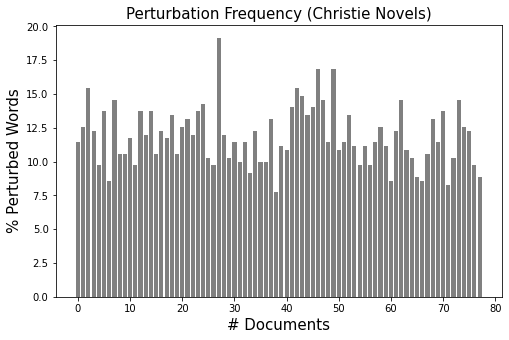

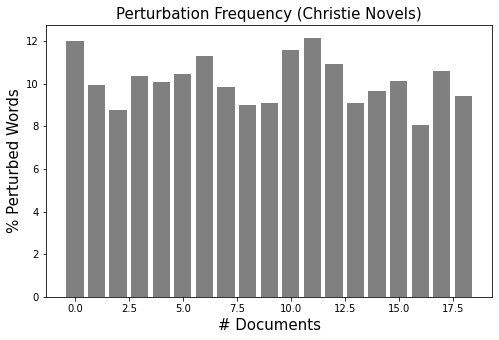

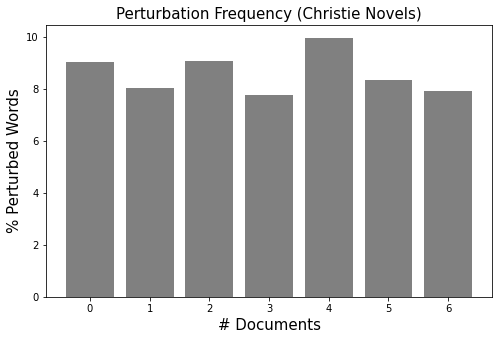

In [ ]:
plot_perturbation_freq(chri_10_350, df1.pert_ratio.values.tolist())
plot_perturbation_freq(chri_10_1400, df2.pert_ratio.values.tolist())
plot_perturbation_freq(chri_10_3500, df3.pert_ratio.values.tolist())

# Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import pickle


In [ ]:
#load w2v models
rine_w2v_sent_300 = pickle.load(open('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/rine_w2v_model_dim300_window12_cb.sav', 'rb'))
rine_w2v_sent_50 = pickle.load(open('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/rine_w2v_model_dim50_window12_cb.sav', 'rb'))

doyle_w2v_sent_300 = pickle.load(open('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/doyle_w2v_model_dim300_window12_cb.sav', 'rb'))
doyle_w2v_sent_50 = pickle.load(open('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/doyle_w2v_model_dim50_window12_cb.sav', 'rb'))

christie_w2v_sent_300 = pickle.load(open('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/christie_w2v_model_dim300_window12_cb.sav', 'rb'))
christie_w2v_sent_50 = pickle.load(open('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/christie_w2v_model_dim50_window12_cb.sav', 'rb'))


## Data from each author
(Here you would have to create the training and testing for each author. Now it's only created for Rinehart)

In [ ]:
df_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_350_train.csv')
df_chri_350_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_350_train.csv').sample(n=int(len(df_train)/2.0), replace=False, random_state=1)
df_doyl_350_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_350_train.csv').sample(n=int(len(df_train)/2.0), replace=False, random_state=1)

df_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_350_test.csv')
df_chri_350_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_350_test.csv')
df_doyl_350_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_350_test.csv')


In [ ]:
df_train1 = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_1400_train.csv')
df_chri_1400_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_1400_train.csv').sample(n=int(len(df_train1)/2.0), replace=False, random_state=1)
df_doyl_1400_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_1400_train.csv').sample(n=int(len(df_train1)/2.0), replace=False, random_state=1)

df_test1 = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_1400_test.csv')
df_chri_1400_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_1400_test.csv')
df_doyl_1400_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_1400_test.csv')


In [ ]:
df_train2 = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_3500_train.csv')
df_chri_3500_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_3500_train.csv').sample(n=int(len(df_train2)/2.0), replace=False, random_state=1)
df_doyl_3500_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_3500_train.csv').sample(n=int(len(df_train2)/2.0), replace=False, random_state=1)

df_test2 = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_3500_test.csv')
df_chri_3500_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_3500_test.csv')
df_doyl_3500_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_3500_test.csv')


## Data Perturbation 

### From json-dict-df

In [ ]:
import json
def load_corpus(fn: str) -> list:
    with open(fn) as fd:
        return json.load(fd)


def json_df (test_file):
  # Load documents from JSON file
  docs = load_corpus(test_file)
  num_docs = len(docs)
  print('Loaded', num_docs, 'documents for testing')

  # Process documents
  # Each document is represented as a dictionary with a 'label' and 'text' field
  text = []
  label = []
  for i, doc in enumerate(docs):
    text.append(re.split('#| |\--|\n', doc['text'])) 
    #text.append(re.split('#|\--|\n', doc['text']))
    label.append(doc['label'])

  df = pd.DataFrame(text, columns = ['word_'+str(i) for i in range(len(text[0]))])
  df['Label'] = label
  #print(df)
  return(df)      


### Read json files to df

In [ ]:
#Add the perturbed data paths here
#Read perturbed data
paths_perturbed_data = ['/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/perturbed_data_rinehart/perturbed_langtranslation_rinehart_350.json', 
               '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/perturbed_data_rinehart/perturbed_langtranslation_rinehart_1400.json',
               '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/perturbed_data_rinehart/perturbed_langtranslation_rinehart_3500.json',
               '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/perturbed_data_rinehart/perturbed_synonym_rinehart_350.json',
               '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/perturbed_data_rinehart/perturbed_synonym_rinehart_1400.json',
               '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/perturbed_data_rinehart/perturbed_synonym_rinehart_3500.json']

               
df_pert_350_lang = json_df(paths_perturbed_data[0])
df_pert_1400_lang = json_df(paths_perturbed_data[1]) 
df_pert_3500_lang = json_df(paths_perturbed_data[2])

df_pert_350_syn = json_df(paths_perturbed_data[3])
df_pert_1400_syn = json_df(paths_perturbed_data[4]) 
df_pert_3500_syn = json_df(paths_perturbed_data[5])

Loaded 244 documents for testing
Loaded 61 documents for testing
Loaded 25 documents for testing
Loaded 154 documents for testing
Loaded 60 documents for testing
Loaded 23 documents for testing


## W2V applied to data

In [ ]:
def w2v(df, model, dim):
  data_ls = []
  for i in range(len(df)):
    t = df.loc[i].values.tolist()
    data = []
    for x in t:
      if x in list(model.wv.vocab.keys()):
        kn = model[x].tolist()
        data.append(kn)
      else:
        unk = [0]*dim
        data.append(unk)
    data_ls.append(list(map(lambda x: sum(x)/len(x), zip(*data))))
  return data_ls

## Training MLP model
(You would have to do it for each author with the right w2v)

In [ ]:
def training(df_train, df1, df2, model, dim, filename):
  df_train = df_train.append(df1, ignore_index=True)
  df_train = df_train.append(df2, ignore_index=True)  
  print(df_train.shape)

  train_data = w2v(df_train, model, dim)
  print(len(train_data))
  df_tr = pd.DataFrame(train_data)
  df_tr['author'] = df_train['Label'].values.tolist()

  df_tr = df_tr.sample(frac=1).reset_index(drop=True)

  y_train = df_tr['author']
  x_train = df_tr.drop(['author'], axis=1)

  for i, x in enumerate(y_train.tolist()):
    if (x == 'christie' or x == 'doyle'): 
      y_train[i] = 'other'

  print(np.unique(y_train))
  clf = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=2000, alpha=0.0001,
                    validation_fraction=0.1,
                     solver='sgd', verbose=10,  random_state=2,tol=0.000000001)
  clf.fit(x_train, y_train)
  path = '/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/clf_rinehart/'
  pickle.dump(clf, open(path+filename, 'wb'))

  return clf

In [ ]:
clf_350_50 = training(df_train, df_chri_350_train, df_doyl_350_train, rine_w2v_sent_50, 50, 'clf_350_50.sav')
clf_350_300 = training(df_train, df_chri_350_train, df_doyl_350_train, rine_w2v_sent_300, 300, 'clf_350_300.sav')

(1420, 351)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1420
['other' 'rinehart']
Iteration 1, loss = 0.70931714
Iteration 2, loss = 0.70801000
Iteration 3, loss = 0.70620343
Iteration 4, loss = 0.70448653
Iteration 5, loss = 0.70277013
Iteration 6, loss = 0.70149777
Iteration 7, loss = 0.70044804
Iteration 8, loss = 0.69939151


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iteration 9, loss = 0.69848803
Iteration 10, loss = 0.69772616
Iteration 11, loss = 0.69702753
Iteration 12, loss = 0.69640530
Iteration 13, loss = 0.69573139
Iteration 14, loss = 0.69521179
Iteration 15, loss = 0.69475822
Iteration 16, loss = 0.69436909
Iteration 17, loss = 0.69398373
Iteration 18, loss = 0.69361877
Iteration 19, loss = 0.69328905
Iteration 20, loss = 0.69303101
Iteration 21, loss = 0.69276406
Iteration 22, loss = 0.69252553
Iteration 23, loss = 0.69224827
Iteration 24, loss = 0.69198074
Iteration 25, loss = 0.69169017
Iteration 26, loss = 0.69140962
Iteration 27, loss = 0.69109131
Iteration 28, loss = 0.69079733
Iteration 29, loss = 0.69055217
Iteration 30, loss = 0.69031561
Iteration 31, loss = 0.69008607
Iteration 32, loss = 0.68987975
Iteration 33, loss = 0.68965245
Iteration 34, loss = 0.68944856
Iteration 35, loss = 0.68924254
Iteration 36, loss = 0.68902029
Iteration 37, loss = 0.68880537
Iteration 38, loss = 0.68858777
Iteration 39, loss = 0.68837519
Iteration

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1420
['other' 'rinehart']
Iteration 1, loss = 0.69308825
Iteration 2, loss = 0.69280467
Iteration 3, loss = 0.69239640


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iteration 4, loss = 0.69198161
Iteration 5, loss = 0.69162408
Iteration 6, loss = 0.69123344
Iteration 7, loss = 0.69089196
Iteration 8, loss = 0.69052389
Iteration 9, loss = 0.69022569
Iteration 10, loss = 0.68993328
Iteration 11, loss = 0.68966130
Iteration 12, loss = 0.68937623
Iteration 13, loss = 0.68912023
Iteration 14, loss = 0.68889495
Iteration 15, loss = 0.68866965
Iteration 16, loss = 0.68843439
Iteration 17, loss = 0.68817035
Iteration 18, loss = 0.68794583
Iteration 19, loss = 0.68773549
Iteration 20, loss = 0.68755457
Iteration 21, loss = 0.68728909
Iteration 22, loss = 0.68698637
Iteration 23, loss = 0.68673278
Iteration 24, loss = 0.68646665
Iteration 25, loss = 0.68620610
Iteration 26, loss = 0.68593425
Iteration 27, loss = 0.68568939
Iteration 28, loss = 0.68543229
Iteration 29, loss = 0.68519444
Iteration 30, loss = 0.68497329
Iteration 31, loss = 0.68469730
Iteration 32, loss = 0.68443024
Iteration 33, loss = 0.68416426
Iteration 34, loss = 0.68389484
Iteration 35, 

In [ ]:
clf_1400_50 = training(df_train1, df_chri_1400_train,df_doyl_1400_train, rine_w2v_sent_50, 50, 'clf_1400_50.sav')
clf_1400_300 = training(df_train1, df_chri_1400_train,df_doyl_1400_train, rine_w2v_sent_300, 300, 'clf_1400_300.sav')

(361, 1401)
361
['other' 'rinehart']
Iteration 1, loss = 0.70341151
Iteration 2, loss = 0.70313661
Iteration 3, loss = 0.70276490
Iteration 4, loss = 0.70223313
Iteration 5, loss = 0.70162811
Iteration 6, loss = 0.70103147
Iteration 7, loss = 0.70041649
Iteration 8, loss = 0.69958988
Iteration 9, loss = 0.69898708
Iteration 10, loss = 0.69829073
Iteration 11, loss = 0.69769027
Iteration 12, loss = 0.69704201
Iteration 13, loss = 0.69630317
Iteration 14, loss = 0.69568485
Iteration 15, loss = 0.69511057
Iteration 16, loss = 0.69450260
Iteration 17, loss = 0.69404205
Iteration 18, loss = 0.69343953
Iteration 19, loss = 0.69298151
Iteration 20, loss = 0.69251121
Iteration 21, loss = 0.69211946
Iteration 22, loss = 0.69163970
Iteration 23, loss = 0.69117053
Iteration 24, loss = 0.69083196
Iteration 25, loss = 0.69044628
Iteration 26, loss = 0.69008171
Iteration 27, loss = 0.68972224
Iteration 28, loss = 0.68938364
Iteration 29, loss = 0.68902118
Iteration 30, loss = 0.68872866
Iteration 31

In [ ]:
clf_3500_50 = training(df_train2, df_chri_3500_train,df_doyl_3500_train, rine_w2v_sent_50, 50, 'clf_3500_50.sav')
clf_3500_300 = training(df_train2, df_chri_3500_train,df_doyl_3500_train, rine_w2v_sent_300, 300, 'clf_3500_300.sav')


(144, 3501)
144
['other' 'rinehart']
Iteration 1, loss = 0.70235553
Iteration 2, loss = 0.70224856
Iteration 3, loss = 0.70209736
Iteration 4, loss = 0.70190776
Iteration 5, loss = 0.70168646
Iteration 6, loss = 0.70143721
Iteration 7, loss = 0.70116177
Iteration 8, loss = 0.70086673
Iteration 9, loss = 0.70055523
Iteration 10, loss = 0.70023214
Iteration 11, loss = 0.69989705
Iteration 12, loss = 0.69955263
Iteration 13, loss = 0.69920298
Iteration 14, loss = 0.69885172
Iteration 15, loss = 0.69849821
Iteration 16, loss = 0.69814760
Iteration 17, loss = 0.69780423
Iteration 18, loss = 0.69746363
Iteration 19, loss = 0.69712494
Iteration 20, loss = 0.69678887
Iteration 21, loss = 0.69645802
Iteration 22, loss = 0.69612949
Iteration 23, loss = 0.69580360
Iteration 24, loss = 0.69548443
Iteration 25, loss = 0.69516972
Iteration 26, loss = 0.69486157
Iteration 27, loss = 0.69455829
Iteration 28, loss = 0.69425962
Iteration 29, loss = 0.69396613
Iteration 30, loss = 0.69367657
Iteration 31

In [ ]:
import warnings
warnings.filterwarnings("ignore")


## Testing MLP model

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title,
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [ ]:
def testing(df_test, df1, df2, model, filename, dim):
  path = '/content/drive/My Drive/ECE 692/project2/word2vec models and data/clf/'
  clf = pickle.load(open(path+filename, 'rb'))
  df_test = df_test.append(df1, ignore_index=True)
  df_test = df_test.append(df2, ignore_index=True)  
  test_data = w2v(df_test, model,dim)

  df_te = pd.DataFrame(test_data)
  df_te['author'] = df_test['Label'].values.tolist()

  df_te = df_te.sample(frac=1).reset_index(drop=True)

  y_test = df_te['author']
  x_test = df_te.drop(['author'], axis=1)

  for i, x in enumerate(y_test.tolist()):
    if (x == 'christie' or x == 'doyle'): 
      y_test[i] = 'other'

  y_pred = clf.predict(x_test)
  print('Test Accuracy: ', accuracy_score(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  print('F1 Score: ', f1_score(y_test, y_pred, average='micro'))
  plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['Others', 'Rinehart'],
                      title        = "Confusion Matrix")

  return y_test, y_pred

In [ ]:
def pert_testing(df_test, model, filename, dim):
  path = '/content/drive/My Drive/ECE 692/project2/word2vec models and data/clf/'
  clf = pickle.load(open(path+filename, 'rb'))
  test_data = w2v(df_test, model,dim)

  df_te = pd.DataFrame(test_data)
  df_te['author'] = df_test['Label'].values.tolist()

  df_te = df_te.sample(frac=1).reset_index(drop=True)

  y_test = df_te['author']
  x_test = df_te.drop(['author'], axis=1)

  for i, x in enumerate(y_test.tolist()):
    if (x == 'christie' or x == 'doyle'): 
      y_test[i] = 'other'

  y_pred = clf.predict(x_test)
  print('Test Accuracy: ', accuracy_score(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  print('F1 Score: ', f1_score(y_test, y_pred, average='micro'))
  plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['Others', 'Rinehart'],
                      title        = "Confusion Matrix")

  return y_test, y_pred

Testing on Original Test Data with Embedding Dimension = 50:

Data Units: 350
Test Accuracy:  0.946058091286307
F1 Score:  0.946058091286307


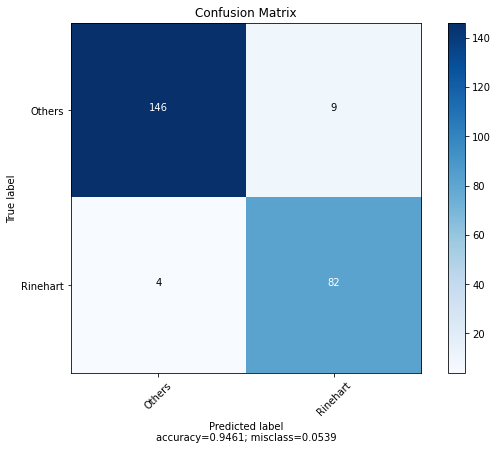


Data Units: 1400
Test Accuracy:  0.9833333333333333
F1 Score:  0.9833333333333333


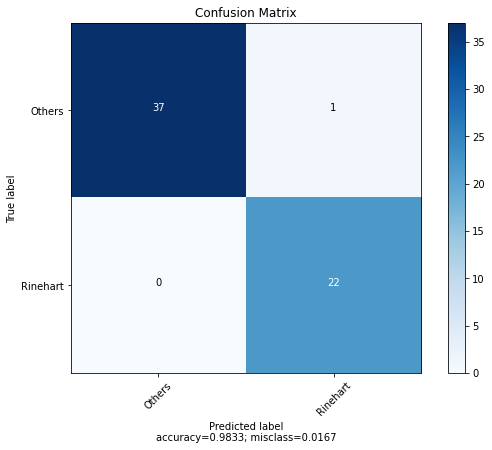


Data Units: 3500
Test Accuracy:  1.0
F1 Score:  1.0


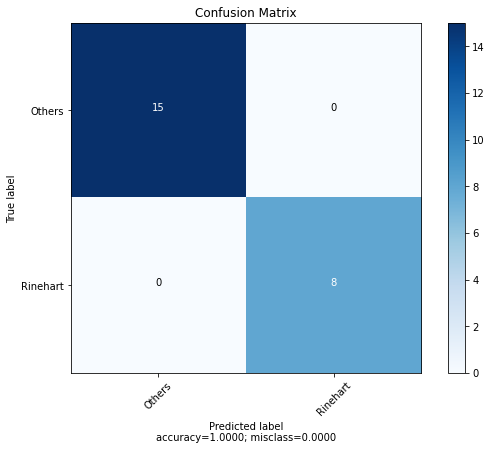

In [ ]:
print('Testing on Original Test Data with Embedding Dimension = 50:')
print('\nData Units: 350')
y_test_350_50, y_pred_350_50 = testing(df_test, df_chri_350_test, df_doyl_350_test, rine_w2v_sent_50, 'clf_350_50.sav', 50)

print('\nData Units: 1400')
y_test_1400_50, y_pred_1400_50 = testing(df_test1, df_chri_1400_test, df_doyl_1400_test, rine_w2v_sent_50, 'clf_1400_50.sav', 50)

print('\nData Units: 3500')
y_test_3500_50, y_pred_3500_50 = testing(df_test2, df_chri_3500_test, df_doyl_3500_test, rine_w2v_sent_50, 'clf_3500_50.sav', 50)

Testing on Original Test Data with Embedding Dimension = 300:

Data Units: 350
Test Accuracy:  0.9294605809128631
F1 Score:  0.9294605809128631


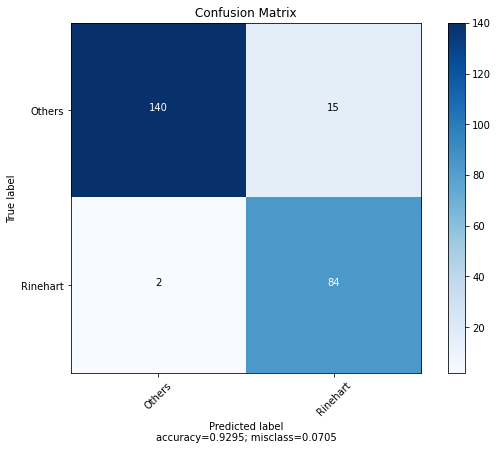


Data Units: 1400
Test Accuracy:  0.9833333333333333
F1 Score:  0.9833333333333333


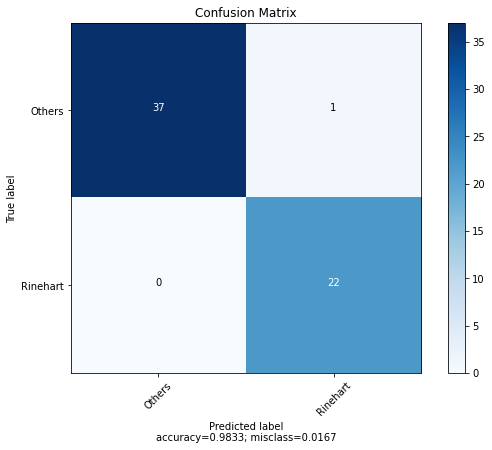


Data Units: 3500
Test Accuracy:  1.0
F1 Score:  1.0


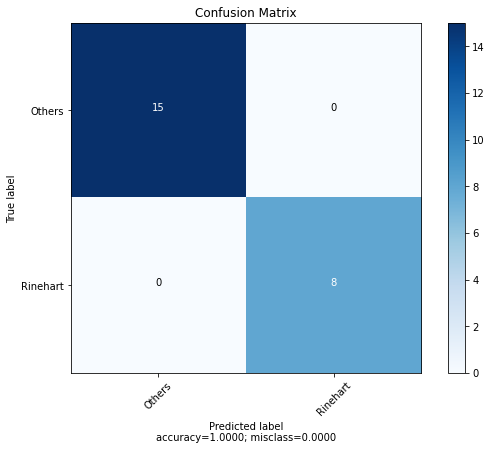

In [ ]:
print('Testing on Original Test Data with Embedding Dimension = 300:')
print('\nData Units: 350')
y_test_350_300, y_pred_350_300 = testing(df_test, df_chri_350_test, df_doyl_350_test, rine_w2v_sent_300, 'clf_350_300.sav', 300)

print('\nData Units: 1400')
y_test_1400_300, y_pred_1400_300 = testing(df_test1, df_chri_1400_test, df_doyl_1400_test, rine_w2v_sent_300, 'clf_1400_300.sav', 300)

print('\nData Units: 3500')
y_test_3500_300, y_pred_3500_300 = testing(df_test2, df_chri_3500_test, df_doyl_3500_test, rine_w2v_sent_300, 'clf_3500_300.sav', 300)

Testing on Perturbed (Language Translation) Test Data with Embedding Dimension = 50:

Data Units: 350
Test Accuracy:  0.9221311475409836
F1 Score:  0.9221311475409836


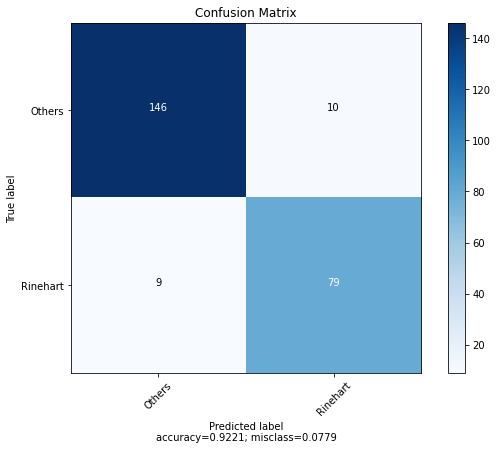


Data Units: 1400
Test Accuracy:  0.9672131147540983
F1 Score:  0.9672131147540983


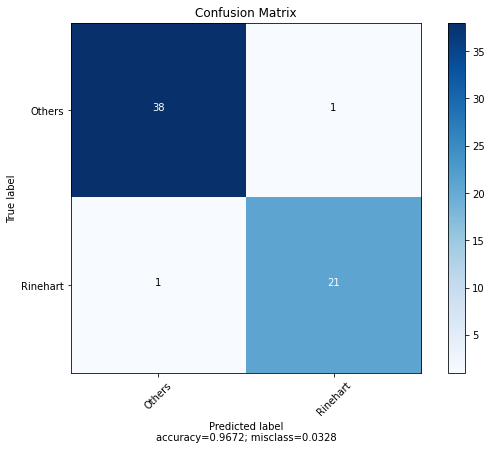


Data Units: 3500
Test Accuracy:  0.96
F1 Score:  0.96


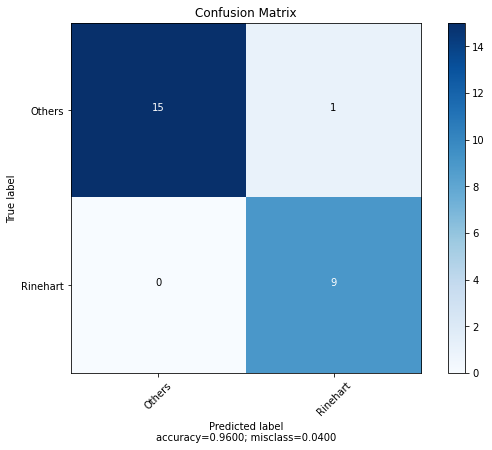

In [ ]:
print('Testing on Perturbed (Language Translation) Test Data with Embedding Dimension = 50:')
print('\nData Units: 350')
y_test_350_50_lang, y_pred_350_50_lang = pert_testing(df_pert_350_lang, rine_w2v_sent_50, 'clf_350_50.sav', 50)

print('\nData Units: 1400')
y_test_1400_50_lang, y_pred_1400_50_lang = pert_testing(df_pert_1400_lang, rine_w2v_sent_50, 'clf_1400_50.sav', 50)

print('\nData Units: 3500')
y_test_3500_50_lang, y_pred_3500_50_lang = pert_testing(df_pert_3500_lang, rine_w2v_sent_50, 'clf_3500_50.sav', 50)

Testing on Perturbed (Synonym Replacement) Test Data with Embedding Dimension = 50:

Data Units: 350
Test Accuracy:  0.948051948051948
F1 Score:  0.948051948051948


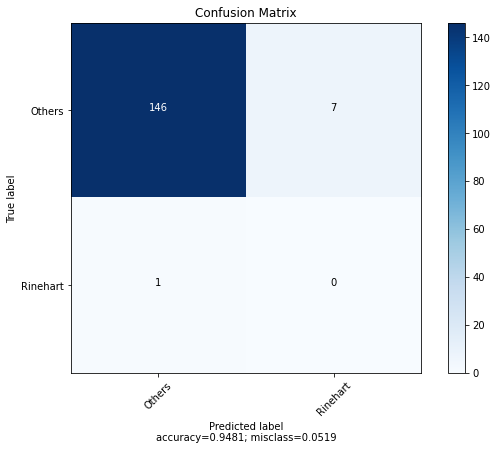


Data Units: 1400
Test Accuracy:  0.9666666666666667
F1 Score:  0.9666666666666667


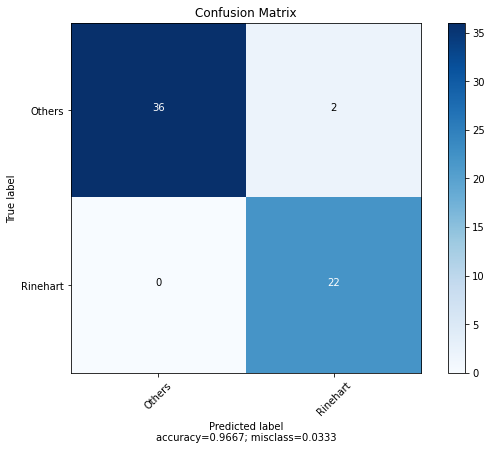


Data Units: 3500
Test Accuracy:  1.0
F1 Score:  1.0


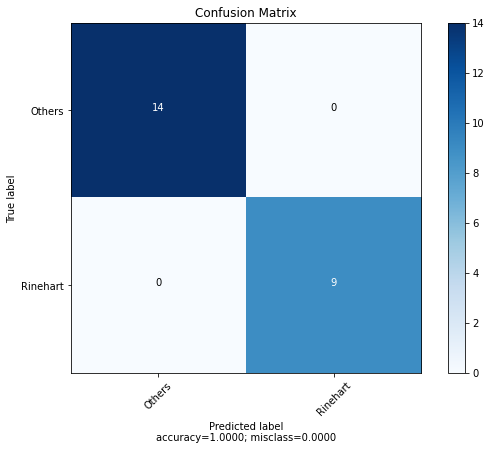

In [ ]:
print('Testing on Perturbed (Synonym Replacement) Test Data with Embedding Dimension = 50:')
print('\nData Units: 350')
y_test_350_50_syn, y_pred_350_50_syn = pert_testing(df_pert_350_syn, rine_w2v_sent_50, 'clf_350_50.sav', 50)

print('\nData Units: 1400')
y_test_1400_50_syn, y_pred_1400_50_syn = pert_testing(df_pert_1400_syn, rine_w2v_sent_50, 'clf_1400_50.sav', 50)

print('\nData Units: 3500')
y_test_3500_50_syn, y_pred_3500_50_syn = pert_testing(df_pert_3500_syn, rine_w2v_sent_50, 'clf_3500_50.sav', 50)

Testing on Perturbed (Language Translation) Test Data with Embedding Dimension = 300:

Data Units: 350
Test Accuracy:  0.9139344262295082
F1 Score:  0.9139344262295082


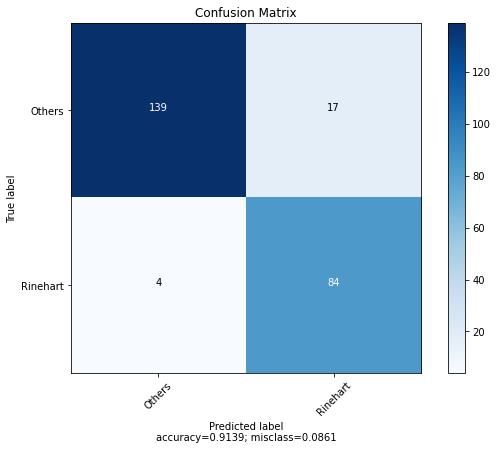


Data Units: 1400
Test Accuracy:  0.9836065573770492
F1 Score:  0.9836065573770492


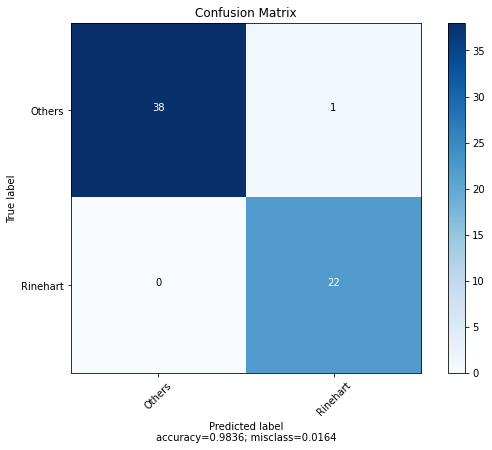


Data Units: 3500
Test Accuracy:  1.0
F1 Score:  1.0


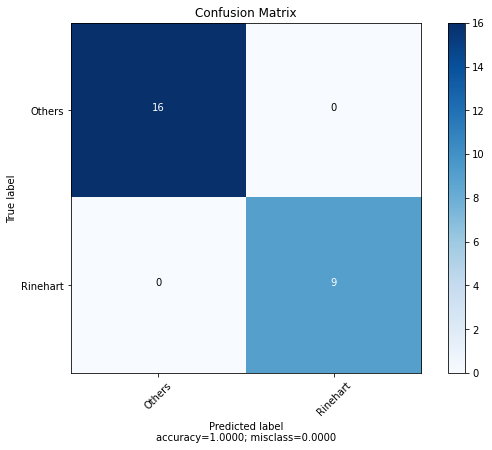

In [ ]:
print('Testing on Perturbed (Language Translation) Test Data with Embedding Dimension = 300:')
print('\nData Units: 350')
y_test_350_300_lang, y_pred_350_300_lang = pert_testing(df_pert_350_lang, rine_w2v_sent_300, 'clf_350_300.sav', 300)

print('\nData Units: 1400')
y_test_1400_300_lang, y_pred_1400_300_lang = pert_testing(df_pert_1400_lang, rine_w2v_sent_300, 'clf_1400_300.sav', 300)

print('\nData Units: 3500')
y_test_3500_300_lang, y_pred_3500_300_lang = pert_testing(df_pert_3500_lang, rine_w2v_sent_300, 'clf_3500_300.sav', 300)

Testing on Perturbed (Synonym Replacement) Test Data with Embedding Dimension = 300:

Data Units: 350
Test Accuracy:  0.922077922077922
F1 Score:  0.922077922077922


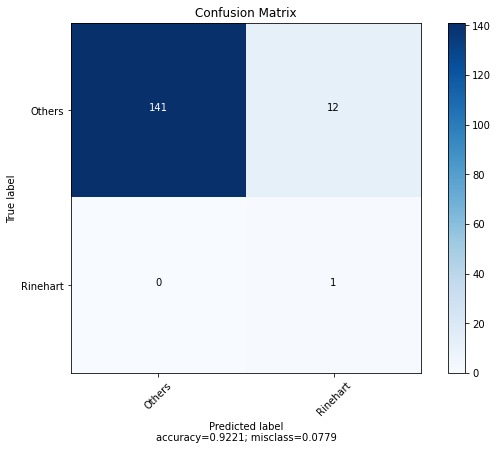


Data Units: 1400
Test Accuracy:  0.9833333333333333
F1 Score:  0.9833333333333333


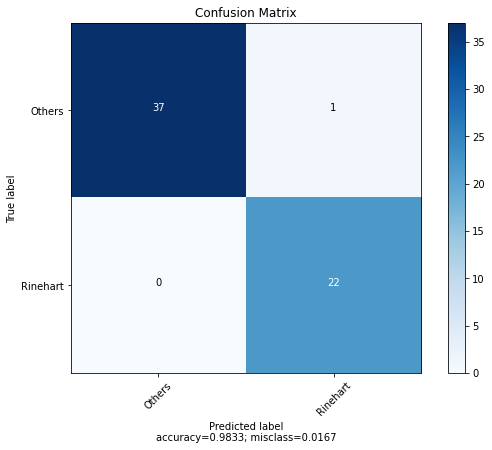


Data Units: 3500
Test Accuracy:  1.0
F1 Score:  1.0


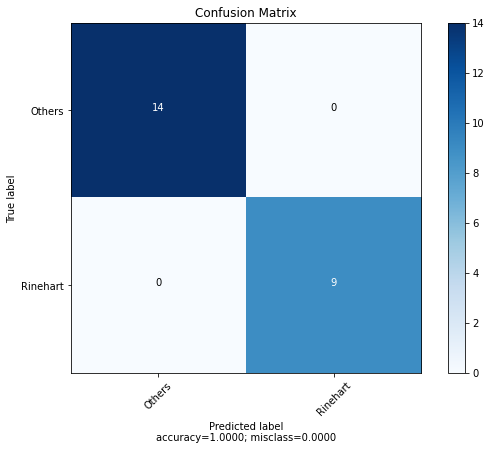

In [ ]:
print('Testing on Perturbed (Synonym Replacement) Test Data with Embedding Dimension = 300:')
print('\nData Units: 350')
y_test_350_300_syn, y_pred_350_300_syn = pert_testing(df_pert_350_syn, rine_w2v_sent_300, 'clf_350_300.sav', 300)

print('\nData Units: 1400')
y_test_1400_300_syn, y_pred_1400_300_syn = pert_testing(df_pert_1400_syn, rine_w2v_sent_300, 'clf_1400_300.sav', 300)

print('\nData Units: 3500')
y_test_3500_300_syn, y_pred_3500_300_syn = pert_testing(df_pert_3500_syn, rine_w2v_sent_300, 'clf_3500_300.sav', 300)